In [63]:
import tensorflow as tf

In [64]:
from tensorflow.keras.utils import image_dataset_from_directory
import os.path
from pathlib import Path
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns

## DATA EXPLORATION

### Load data

In [65]:
!pwd

/Users/thomas/code/wroby/foodE/notebooks


In [66]:
PATH = "../raw_data/food-101/food-101-train/images"
PATH_test = "../raw_data/food-101/food-101-test/images"


### Train/test split

In [67]:
img_height = 64
img_width = 64
batch_size = 32

In [68]:
train = image_dataset_from_directory(PATH,label_mode="categorical", color_mode="rgb",
                                     labels='inferred',
                                     class_names=['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_soup', 'mussels', 'nachos', 'omelette', 'onion_rings', 'oysters', 'pad_thai', 'paella', 'pancakes', 'panna_cotta', 'peking_duck', 'pho', 'pizza', 'pork_chop', 'poutine', 'prime_rib', 'pulled_pork_sandwich', 'ramen', 'ravioli', 'red_velvet_cake', 'risotto', 'samosa', 'sashimi', 'scallops', 'seaweed_salad', 'shrimp_and_grits', 'spaghetti_bolognese', 'spaghetti_carbonara', 'spring_rolls', 'steak', 'strawberry_shortcake', 'sushi', 'tacos', 'takoyaki', 'tiramisu', 'tuna_tartare', 'waffles'],
                                  validation_split=0.2, subset="training",
                                  image_size=(img_height,img_width), interpolation="bilinear",
                                  crop_to_aspect_ratio=True,
                                  seed=42, shuffle=True, batch_size=batch_size)

Found 80800 files belonging to 101 classes.
Using 64640 files for training.


In [69]:
validation = image_dataset_from_directory(PATH,label_mode="categorical", color_mode="rgb",
                                          labels='inferred',
                                  validation_split=0.2, subset="validation",
                                  image_size=(img_height,img_width), interpolation="bilinear",
                                  crop_to_aspect_ratio=True,
                                  seed=42, shuffle=True, batch_size=batch_size)

Found 80800 files belonging to 101 classes.
Using 16160 files for validation.


In [70]:
test = image_dataset_from_directory(PATH_test, label_mode="categorical", color_mode="rgb", 
                                    labels='inferred',
                                  image_size=(img_height,img_width), interpolation="bilinear",
                                  crop_to_aspect_ratio=True,
                                  seed=42, shuffle=True, batch_size=batch_size)

Found 20200 files belonging to 101 classes.


In [71]:
#label name
class_names = train.class_names
print("Class names:", class_names)

Class names: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macaron

### Visualise datasets


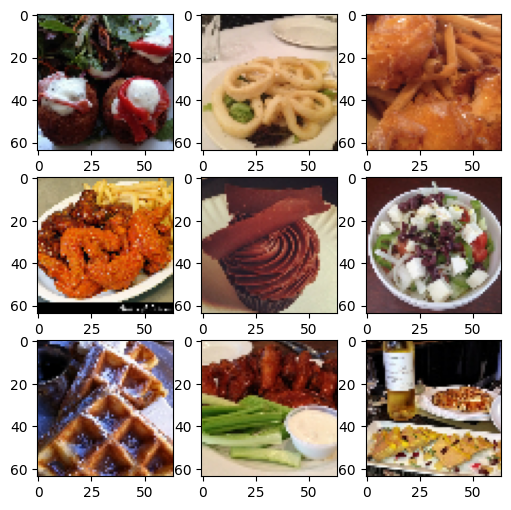

In [72]:
fig, ax = plt.subplots(3, 3, figsize=(6,6))
 
for images, labels in train.take(1):
    for i in range(3):
        ax[0][i].imshow(images[i].numpy().astype("uint8"))
    for i in range(3):
        ax[1][i].imshow(images[i+3].numpy().astype("uint8"))
    for i in range(3):
        ax[2][i].imshow(images[i+6].numpy().astype("uint8"))
plt.show()

## Preprocessing

#### Model to choose
VGG16 - celui du cours, mais il est un peu pété -
MobileNetV2 - solide et légé mais moins accurate -
EfficientnetB2 - celui la est top mais prends bcp de ressources -
InceptionV3 : 88.28% / 96.88% (Top 1/Top 5) - tres souvent utilisé -
ResNet200 : 90.14% (Top 1) - tres souvent utilisé -
WISeR : 90.27% / 98.71% (Top 1/Top 5) - pas vu tres souvent -

In [73]:
## Definir la function preprocess
def preprocessing(images, labels):
    ## Use the preprocess_input for each specific model
    return tf.keras.applications.mobilenet_v2.preprocess_input(tf.image.convert_image_dtype(images, tf.float32)), labels
    ## will scale input pixels between -1 and 1
    
## Appliquer la function sur le dataset
train = train.map(preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
validation = validation.map(preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
test = test.map(preprocessing, num_parallel_calls=tf.data.AUTOTUNE)

In [74]:
# Cache the preprocessed data in memory and prefetch the next batch
AUTOTUNE = tf.data.AUTOTUNE
train = train.cache().prefetch(buffer_size=AUTOTUNE)
validation = validation.cache().prefetch(buffer_size=AUTOTUNE)
test = test.cache().prefetch(buffer_size=AUTOTUNE)

## Model training

### Define the model

In [105]:
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet', 
    pooling='avg'
)

In [106]:
base_model.trainable


True

In [103]:
#base_model.trainable = False

### Add custom layer

In [107]:
regularizer=regularizers.l2(0.005)

In [108]:
model = tf.keras.Sequential([
 ## Data Augmentation layer   
# tf.keras.layers.RandomFlip(mode="horizontal", seed=42), 
# vertical flip to test
# tf.keras.layers.RandomRotation(factor=0.05, seed=42),
# Ajout zoom layer 
# tf.keras.layers.RandomContrast(factor=0.2, seed=42),
## Base model
base_model,
## FNN
tf.keras.layers.Dense(128,activation='relu'),
tf.keras.layers.Dense(128,activation='relu'),
#tf.keras.layers.Dropout(0.3),
tf.keras.layers.Dense(101,activation='softmax')
])

In [109]:
## Build the model for some reason
model.build(input_shape=(None, img_height, img_width, 3))

In [110]:
## Deep Neural Architecture
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense_6 (Dense)             (None, 128)               163968    
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 dense_8 (Dense)             (None, 101)               13029     
                                                                 
Total params: 2,451,493
Trainable params: 2,417,381
Non-trainable params: 34,112
_________________________________________________________________


### Compiling

In [111]:
model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy']
)
# test lr: e-4, e-5, e-6

### Fitting

In [113]:
## Early stopping
es = EarlyStopping(monitor="val_loss",
                    patience=10,
                    mode="auto",
                    restore_best_weights=True)

In [114]:
history = model.fit(
    train, 
    epochs=100, 
    verbose=1,
    validation_data=validation,
    shuffle=True,
    batch_size=batch_size,
    callbacks=[es])   

Epoch 1/100
2020/2020 [==============================] - 202s 99ms/step - loss: 3.9132 - accuracy: 0.1094 - val_loss: 5.9221 - val_accuracy: 0.0730
Epoch 2/100
2020/2020 [==============================] - 198s 98ms/step - loss: 3.4319 - accuracy: 0.1811 - val_loss: 5.8782 - val_accuracy: 0.0543
Epoch 3/100
2020/2020 [==============================] - 199s 98ms/step - loss: 3.2979 - accuracy: 0.2059 - val_loss: 6.7427 - val_accuracy: 0.0581
Epoch 4/100
2020/2020 [==============================] - 198s 98ms/step - loss: 3.2277 - accuracy: 0.2206 - val_loss: 6.6433 - val_accuracy: 0.0572
Epoch 5/100
2020/2020 [==============================] - 202s 100ms/step - loss: 3.2091 - accuracy: 0.2209 - val_loss: 5.2669 - val_accuracy: 0.0994
Epoch 6/100
2020/2020 [==============================] - 194s 96ms/step - loss: 3.2671 - accuracy: 0.2111 - val_loss: 7.2021 - val_accuracy: 0.0249
Epoch 7/100
2020/2020 [==============================] - 202s 100ms/step - loss: 3.1057 - accuracy: 0.2398 - va

### Evalute

In [84]:
results = model.evaluate(test, verbose=1)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

632/632 [==============================] - 18s 29ms/step - loss: 3.1857 - accuracy: 0.2537
Test Accuracy: 25.37%


### Predict

In [85]:
predictions = np.argmax(model.predict(test), axis=1)

632/632 [==============================] - 106s 166ms/step


In [86]:
# confusion matrix
# classication report
# heatmap
# exemples de mauvaises predictions

### Extract labels

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Create an empty list to store the true labels
true_labels = []

# Create an empty list to store the predicted labels
pred_labels = []

# Iterate over the test dataset and store the true and predicted labels
for images, label in test:
    true_labels.extend(np.argmax(label, axis=1).tolist())
    predictions = model.predict(images)
    pred_labels.extend(np.argmax(predictions, axis=1).tolist())

# Convert the lists to numpy arrays
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)



1/1 [==============================] - 0s 392ms/step


### Confusion Matrix

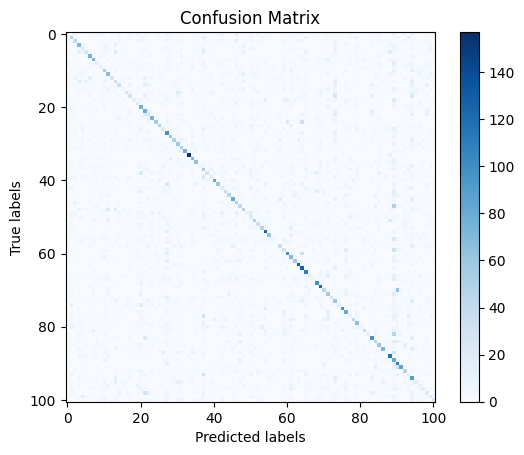

In [92]:

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.colorbar()
plt.show()

### Classification reports

In [93]:
import numpy as np
from sklearn.metrics import classification_report

Get label name

In [94]:
# Generate the classification report
report = classification_report(true_labels, pred_labels, target_names=['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_soup', 'mussels', 'nachos', 'omelette', 'onion_rings', 'oysters', 'pad_thai', 'paella', 'pancakes', 'panna_cotta', 'peking_duck', 'pho', 'pizza', 'pork_chop', 'poutine', 'prime_rib', 'pulled_pork_sandwich', 'ramen', 'ravioli', 'red_velvet_cake', 'risotto', 'samosa', 'sashimi', 'scallops', 'seaweed_salad', 'shrimp_and_grits', 'spaghetti_bolognese', 'spaghetti_carbonara', 'spring_rolls', 'steak', 'strawberry_shortcake', 'sushi', 'tacos', 'takoyaki', 'tiramisu', 'tuna_tartare', 'waffles'])

# Print the classification report
print(report)

                         precision    recall  f1-score   support

              apple_pie       0.05      0.01      0.02       200
         baby_back_ribs       0.17      0.24      0.20       200
                baklava       0.23      0.21      0.22       200
         beef_carpaccio       0.29      0.36      0.32       200
           beef_tartare       0.14      0.12      0.13       200
             beet_salad       0.24      0.12      0.16       200
               beignets       0.45      0.38      0.41       200
               bibimbap       0.31      0.37      0.34       200
          bread_pudding       0.14      0.06      0.08       200
      breakfast_burrito       0.12      0.07      0.09       200
             bruschetta       0.18      0.26      0.21       200
           caesar_salad       0.27      0.34      0.30       200
                cannoli       0.30      0.13      0.18       200
          caprese_salad       0.14      0.18      0.16       200
            carrot_cake 

### Samples of wrong predictions

/var/folders/sm/pwbr3w7j4fv9cfmbm219c4yh0000gn/T/ipykernel_8021/672683068.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  wrong_indexes = np.where(predictions != true_labels)[0]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


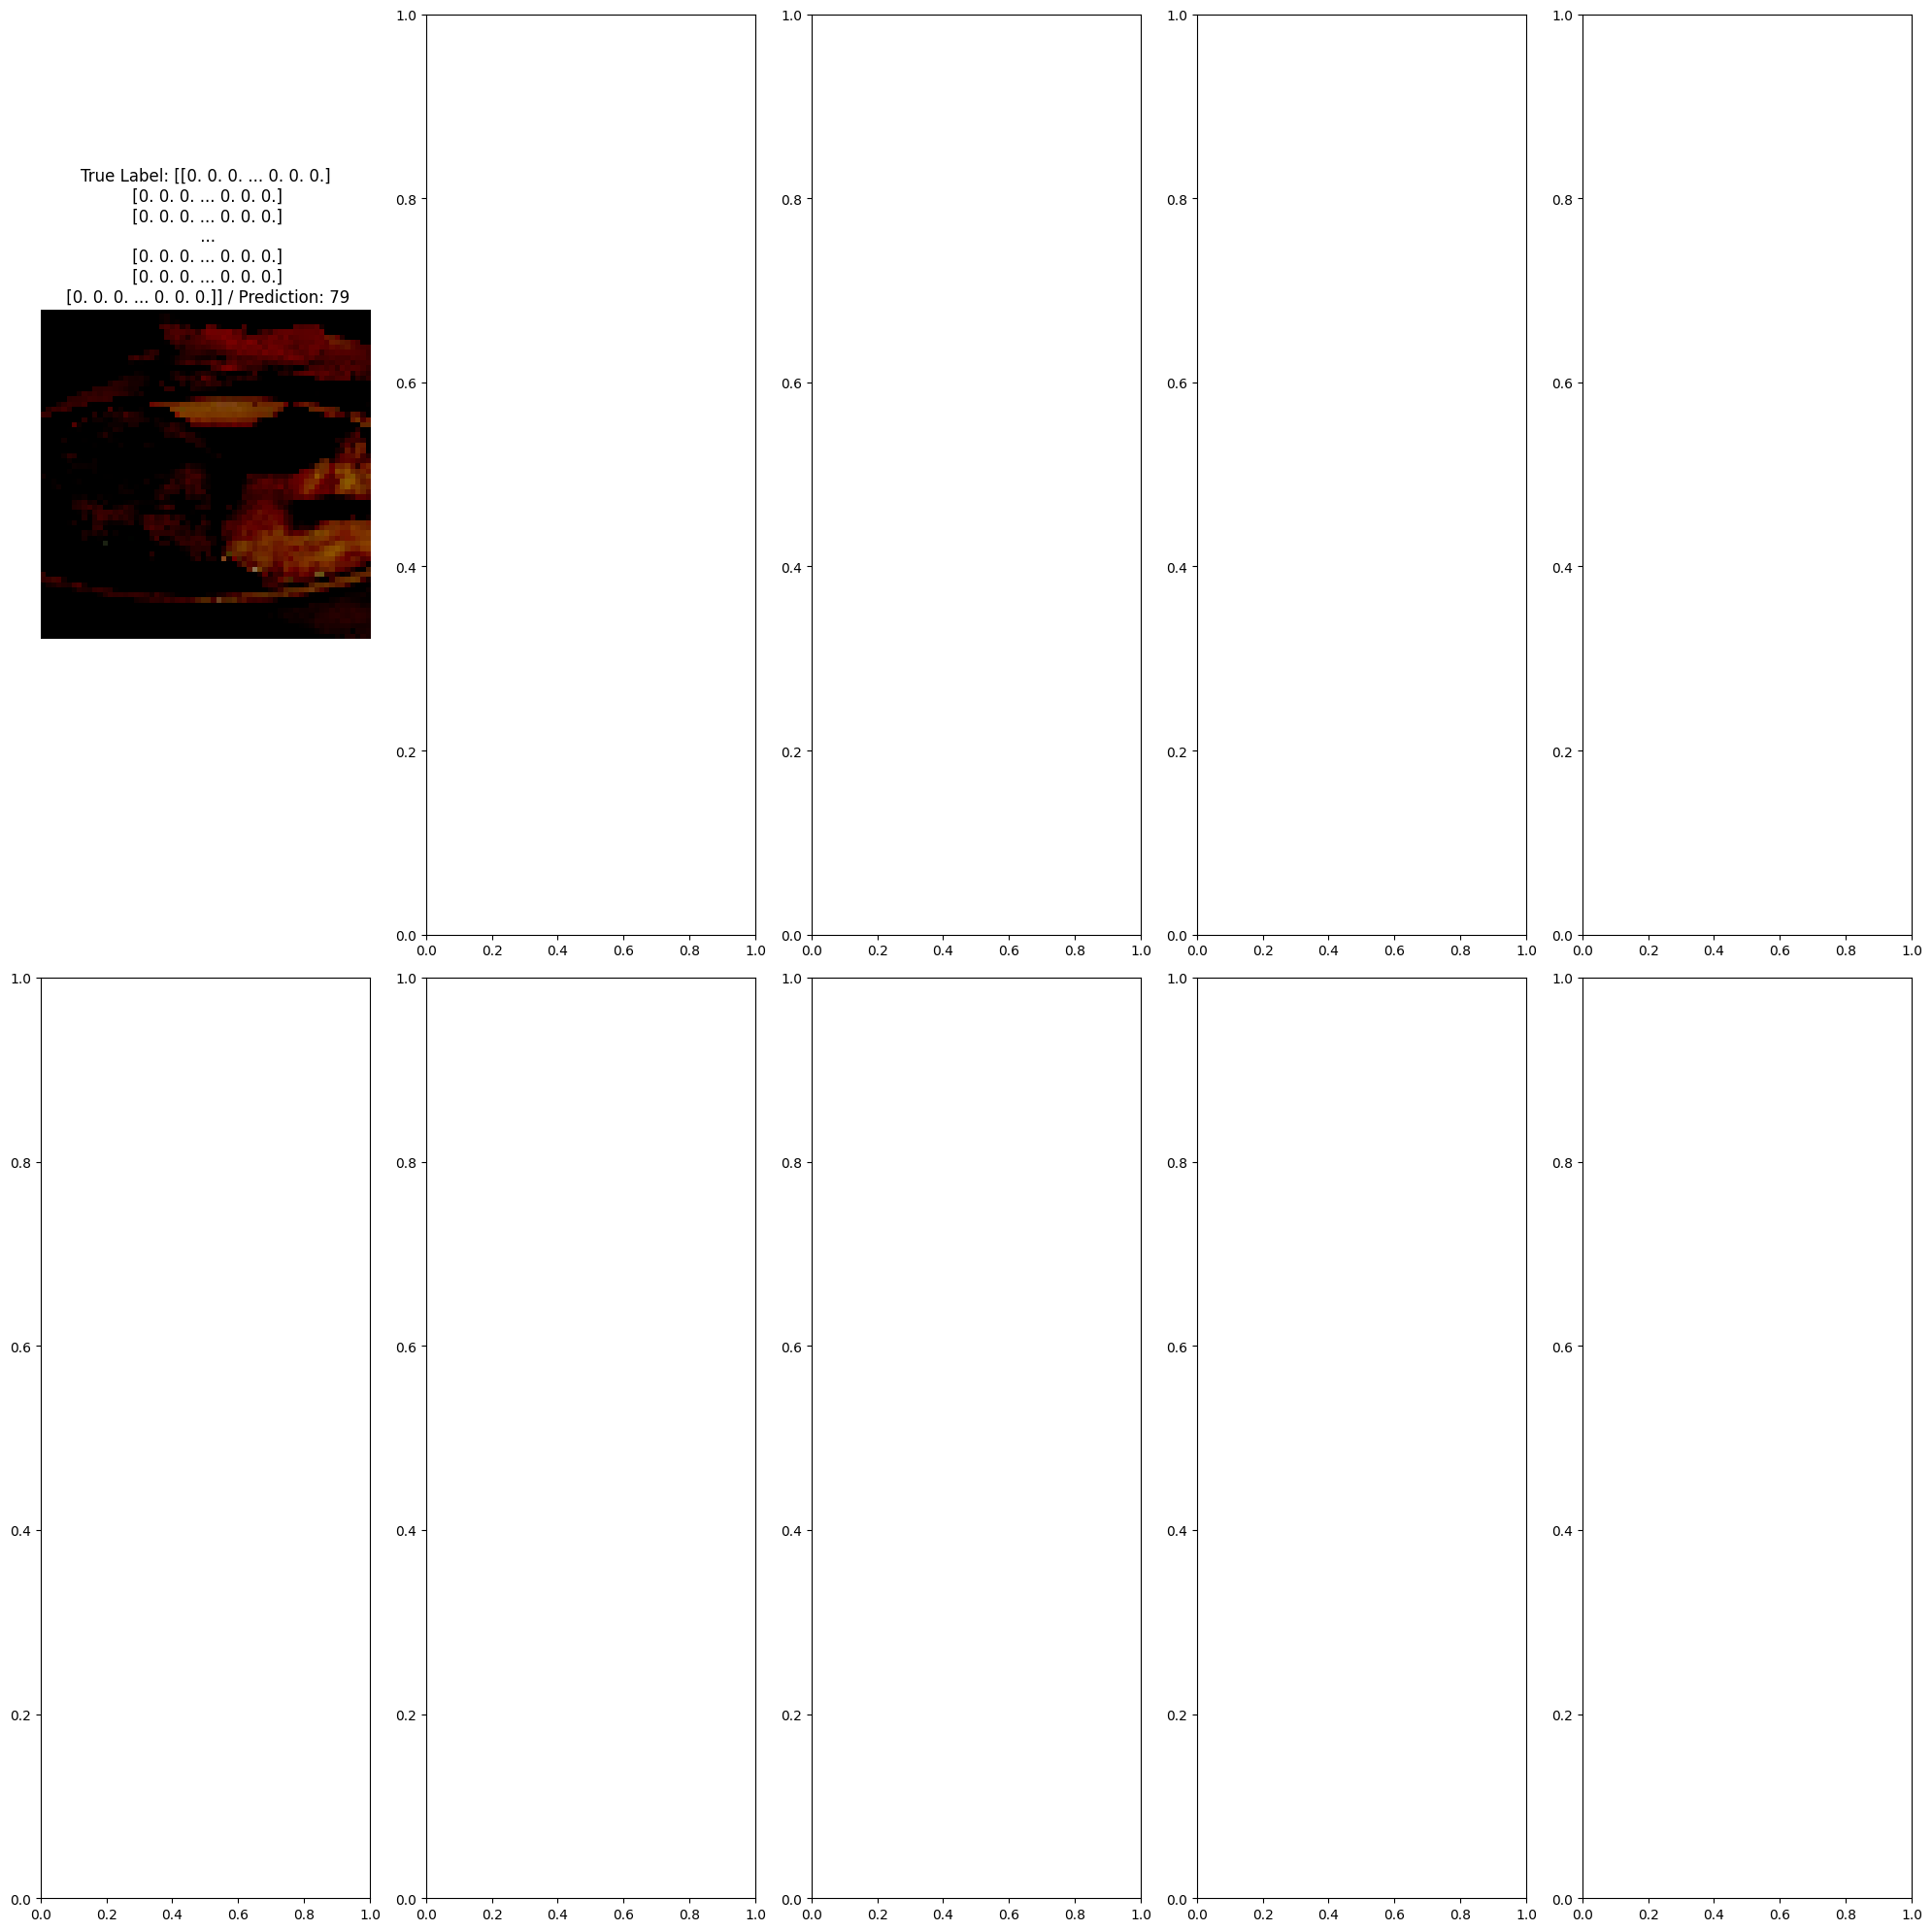

In [89]:
# Get the indexes of the incorrect predictions
wrong_indexes = np.where(predictions != true_labels)[0]

# Get the images corresponding to the incorrect predictions
wrong_images = []
for i, (image, label) in enumerate(test.unbatch()):
    if i in wrong_indexes:
        wrong_images.append(image.numpy())

# Plot the wrong predictions
num_images = 5
cols = 5
rows = num_images // cols + 1

fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
axes = axes.ravel()

for i, ax in enumerate(axes):
    if i >= len(wrong_images):
        break
    image = wrong_images[i]
    ax.imshow(image)
    ax.set_title(f"True Label: {true_labels[i]} / Prediction: {predictions[i]}")

    ax.axis("off")

plt.tight_layout()
plt.show()
